In [1]:
import datetime
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from collections import defaultdict
from itertools import repeat, combinations
from pandarallel import pandarallel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, plot_heatmap,
    get_cols, insert_row_number, plot_train_test_distribution
)
from utils.extraction_helpers import read_file
from utils.feature_group import CATEGORY_COLUMNS

In [4]:
%load_ext autoreload
%autoreload

In [5]:
pandarallel.initialize(nb_workers=16, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
START = time.time()

In [7]:
def combine_binary_features(train, test, final_col_name, col_list, sufficient_count=500, drop_ori=False):
    train["temp"] = train[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    test["temp"] = test[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    le = LabelEncoder()
    le.fit(train["temp"])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df = train.groupby("temp").agg(
        target_count=("target", "count")
    )
    less_count_cat_codes = train_df.loc[train_df["target_count"] < sufficient_count].index.tolist()
    le_dict = {k: v if k not in less_count_cat_codes else np.nan for k, v in le_dict.items()}
    train[final_col_name] = train["temp"].map(le_dict).astype("category")
    test[final_col_name] = test["temp"].map(le_dict).astype("category")
    if drop_ori:
        train.drop(columns=col_list, inplace=True)
        test.drop(columns=col_list, inplace=True)
    return train, test

### Read Data

In [8]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [9]:
%%time
train = read_file(f"../{INTERIM_DATA_PATH}/v4/train_parquet/train_all_variables.parquet")
test1 = read_file(f"../{INTERIM_DATA_PATH}/v4/test_parquet/test_all_variables1.parquet")
test2 = read_file(f"../{INTERIM_DATA_PATH}/v4/test_parquet/test_all_variables2.parquet")

Shape of data: (5531451, 192)
Shape of data: (5681079, 191)
Shape of data: (5682683, 191)
CPU times: user 54.4 s, sys: 1min 44s, total: 2min 38s
Wall time: 2min 27s


In [10]:
test = pd.concat([test1, test2], ignore_index=True)
del test1, test2

In [11]:
gc.collect()

188

In [12]:
# for df in df_list:
#     df["D_135"] = df["D_135"].fillna(-1)
#     df["D_137"] = df["D_137"].fillna(-1)

In [17]:
for col in train.columns[5:]:
    if train[col].min() != test[col].min():
        print(col, train[col].min(), test[col].min())

S_3 -0.6299999952316284 -0.6899999976158142
P_3 -1.5199999809265137 -1.5099999904632568
S_7 -0.47999998927116394 -0.5199999809265137
P_4 0.7699999809265137 0.7799999713897705
S_23 -206.08999633789062 -446.9599914550781
B_1 -7.590000152587891 -7.059999942779541
B_7 -2.6600000858306885 -6.679999828338623
B_14 -8.470000267028809 -32.22999954223633
B_15 -10.010000228881836 -38.099998474121094
B_25 -11.260000228881836 -4.75
B_37 -7.610000133514404 -7.079999923706055
B_723 -2.6500000953674316 -6.670000076293945
D_46 -17.290000915527344 -8.739999771118164
D_66 0.0 1.0
D_73 -0.05000000074505806 -0.12999999523162842


,customer_ID,row_number,row_number_inv,S_2,P_2,S_3,P_3,S_5,S_6,S_7,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,9,1,2019-02-19,0.63,0.16,NaN,0.0,1,0.10,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,8,2,2019-03-25,0.58,0.24,NaN,0.0,1,0.16,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,7,3,2019-04-25,0.60,0.26,NaN,0.0,0,0.21,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,6,4,2019-05-20,0.61,0.18,NaN,0.0,0,0.19,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,5,5,2019-06-15,0.59,0.18,0.59,0.0,0,0.20,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363757,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,5,4,2018-12-19,0.44,NaN,0.61,NaN,1,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
11363758,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,4,5,2019-01-19,0.44,NaN,0.61,NaN,1,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
11363759,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,3,6,2019-02-17,0.46,NaN,0.62,NaN,1,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0
11363760,fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61...,2,7,2019-03-19,0.46,NaN,0.62,NaN,1,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0


#### Train

In [13]:
%%time
train_agg, keep_column = feature_gen_pipeline(train)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:37<00:00,  4.71it/s]

CPU times: user 1min 3s, sys: 33.6 s, total: 1min 37s
Wall time: 1min 48s


In [14]:
train_agg["target"] = labels["target"].values
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 13.907754725 GB, Shape: (458913, 4974)


In [15]:
float64_columns = train_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = train_agg[col].astype(np.float32).values
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2588/2588 [00:32<00:00, 79.97it/s]


In [16]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.202978649 GB, Shape: (458913, 4974)


In [17]:
number_columns = train_agg.select_dtypes(np.number).columns.tolist()
for col in tqdm(number_columns):
    temp = train_agg[col].round(3)
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].round(3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4930/4930 [00:17<00:00, 278.48it/s]


In [18]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.202978649 GB, Shape: (458913, 4974)


In [19]:
%%time
train_agg = train_agg.loc[:, keep_column]

CPU times: user 1.37 s, sys: 9.09 s, total: 10.5 s
Wall time: 17.4 s


In [20]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 8.872561289 GB, Shape: (458913, 4796)


In [21]:
train_agg.to_parquet(f"./train_agg.parquet")

In [22]:
del train_agg, train

### Test 1

In [12]:
%%time
test_agg, keep_column = feature_gen_pipeline(test1)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:37<00:00,  4.73it/s]

CPU times: user 1min 3s, sys: 38.8 s, total: 1min 42s
Wall time: 1min 59s


In [13]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 14.018005763 GB, Shape: (462311, 4973)


In [25]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2594/2594 [00:29<00:00, 89.01it/s]


In [26]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.265448683 GB, Shape: (462311, 4973)


In [27]:
test_agg = test_agg.loc[:, keep_column]

In [28]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.936283251 GB, Shape: (462311, 4796)


In [29]:
test_agg.to_parquet(f"./test_agg1.parquet")

In [30]:
del test_agg

In [ ]:
del test1

### Test 2

In [31]:
%%time
test_agg, keep_column = feature_gen_pipeline(test2)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:36<00:00,  4.78it/s]

CPU times: user 1min 2s, sys: 23.8 s, total: 1min 26s
Wall time: 1min 32s


In [32]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 14.017975478 GB, Shape: (462310, 4973)


In [33]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2594/2594 [00:30<00:00, 85.60it/s]


In [34]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.265428678 GB, Shape: (462310, 4973)


In [35]:
%%time
test_agg = test_agg.loc[:, keep_column]

CPU times: user 1.56 s, sys: 11 s, total: 12.6 s
Wall time: 21 s


In [36]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.936263958 GB, Shape: (462310, 4796)


In [37]:
test_agg.to_parquet(f"./test_agg2.parquet")

In [38]:
del test_agg

### END

In [39]:
END = time.time()

In [41]:
print(f"{END - START:.2f} seconds elapsed")

609.93 seconds elapsed


### Prepare final features for training

In [17]:
def select_bad_features(feature_imp_df, threshold):
    bad_features = []
    feature_imp_df = feature_imp_df.fillna(0)
    for type_ in feature_imp_df.columns[1:]:
        bad_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return bad_features

In [18]:
def select_good_features(feature_imp_df, threshold):
    good_features = []
    for type_ in feature_imp_df.columns[1:]:
        good_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] >= threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return good_features

### Train

In [10]:
%%time
train_agg = read_file(f"./train_agg.parquet")

Shape of data: (458913, 4797)
CPU times: user 17.3 s, sys: 25.3 s, total: 42.6 s
Wall time: 26.1 s


In [11]:
train_agg.head(3)

,customer_ID,R_11_avg,D_96_last_minus_avg,B_7_min,B_723_displacement,R_22_ma2_r2,D_76_second_last,D_109_ma3_r1,D_128_ma3_r1_r2,D_62_min,...,D_62_ma3_r1_r2,D_74_ma3_r1,B_32_displacement,D_145_acceleration,B_12_max,D_103_last_minus_avg,D_135_avg,B_6_second_last,D_105_max,D_134_avg
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.000000,0.0,0.00,-0.01,0.0,NaN,0.0,1.0,0.08,...,NaN,0.0,0,NaN,0.14,0.0,NaN,0.15,1.07,NaN
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.076923,0.0,0.01,-0.01,0.0,NaN,0.0,1.0,0.23,...,0.985714,0.0,0,NaN,0.03,0.0,NaN,0.21,NaN,NaN
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.000000,0.0,0.02,0.00,0.0,NaN,0.0,NaN,0.15,...,1.287129,0.0,0,NaN,0.01,0.0,NaN,0.17,NaN,NaN


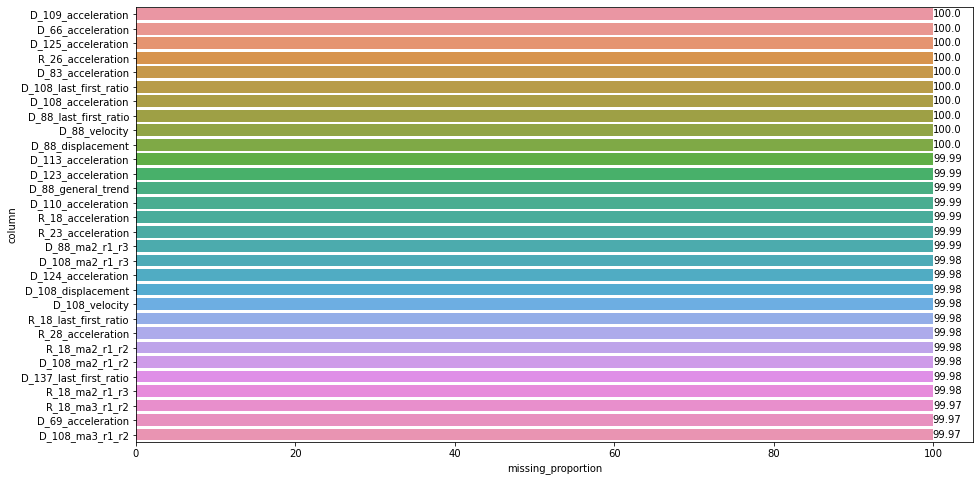

CPU times: user 2.81 s, sys: 1.35 s, total: 4.17 s
Wall time: 3.94 s


In [12]:
%%time
m = plot_missing_proportion_barchart(train_agg)

In [13]:
high_missing_columns = m.loc[m["missing_proportion"] > 99]["column"].tolist()
len(high_missing_columns)

203

In [95]:
%%time
train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")

CPU times: user 754 ms, sys: 1.36 s, total: 2.11 s
Wall time: 3.53 s


In [96]:
train_agg.shape

(458913, 4594)

In [14]:
summary_feature_imp3 = read_file(f"../{EXP_PATH}/3.lgbm_dart_5197/feature_importance.csv")
summary_feature_imp4 = read_file(f"../{EXP_PATH}/4.lgbm_dart_6666/feature_importance.csv")
summary_feature_imp5 = read_file(f"../{EXP_PATH}/5.lgbm_dart_923_half_fix/feature_importance.csv")

Shape of data: (166, 24)
Shape of data: (174, 24)
Shape of data: (181, 39)


In [15]:
median_fi3 = np.percentile(summary_feature_imp3.values[:, 1:].ravel(), 10)
median_fi4 = np.percentile(summary_feature_imp4.values[:, 1:].ravel(), 15)
median_fi5 = np.percentile(summary_feature_imp5.values[:, 1:].ravel(), 10)
median_fi3, median_fi4, median_fi5

(36.940000000000005, 33.2, 5.4)

In [19]:
bad_features = list(
    set(select_bad_features(summary_feature_imp3, 12))
    .intersection(select_bad_features(summary_feature_imp4, 12))
    .intersection(select_bad_features(summary_feature_imp5, 10))
    .intersection(train_agg.columns)
)
len(bad_features)

414

In [20]:
train_agg.shape

(458913, 4797)

In [146]:
%%time
train_agg = train_agg.drop(columns=bad_features)

CPU times: user 412 ms, sys: 2.84 s, total: 3.25 s
Wall time: 5.22 s


In [147]:
train_agg.shape

(458913, 4241)

In [148]:
train_agg.to_parquet(f"./final_train_agg.parquet")

In [149]:
final_columns = train_agg.columns.tolist()

In [21]:
final_cat_columns = get_cols(train_agg, CATEGORY_COLUMNS)
print(final_cat_columns)

['D_68_third_last', 'B_38_third_last', 'D_117_last', 'D_120_first', 'D_68_last', 'B_38_last', 'D_126_third_last', 'D_114_last', 'D_68_second_last', 'D_63_first', 'D_92_last', 'D_126_second_last', 'D_64_last', 'D_116_second_last', 'D_120_second_last', 'D_68_first', 'D_116_third_last', 'B_30_first', 'D_64_third_last', 'B_30_last', 'D_114_first', 'D_114_second_last', 'D_126_last', 'D_63_last', 'D_117_second_last', 'B_30_second_last', 'D_116_last', 'D_92_second_last', 'D_117_third_last', 'D_116_first', 'D_120_third_last', 'D_117_first', 'D_64_second_last', 'D_92_first', 'D_120_last', 'D_92_third_last', 'B_38_first', 'D_126_first', 'D_63_second_last', 'D_114_third_last', 'B_30_third_last', 'D_64_first', 'B_38_second_last', 'D_63_third_last']


In [24]:
del train_agg

In [23]:
drop_features = bad_features + high_missing_columns

### Test

In [9]:
%%time
test_agg1 = read_file(f"./test_agg1.parquet")

Shape of data: (462311, 4796)
CPU times: user 16.1 s, sys: 16.1 s, total: 32.2 s
Wall time: 18.7 s


In [28]:
final_columns = list(set(test_agg1.columns) - set(drop_features))
len(final_columns)

4240

In [30]:
%%time
test_agg1 = test_agg1.loc[:, final_columns]

CPU times: user 478 ms, sys: 3.78 s, total: 4.26 s
Wall time: 10.2 s


In [31]:
%%time
test_agg2 = read_file(f"./test_agg2.parquet")

Shape of data: (462310, 4796)
CPU times: user 15.9 s, sys: 20.6 s, total: 36.5 s
Wall time: 25.9 s


In [32]:
%%time
test_agg2 = test_agg2.loc[:, final_columns]

CPU times: user 401 ms, sys: 2.75 s, total: 3.15 s
Wall time: 4.73 s


In [33]:
test_agg = pd.concat([test_agg1, test_agg2], ignore_index=True)

In [ ]:
del test_agg1, test_agg2

In [ ]:
gc.collect()

In [36]:
test_agg.shape

(924621, 4240)

In [35]:
%%time
test_agg.to_parquet(f"./final_test_agg.parquet")

CPU times: user 1min 10s, sys: 15.7 s, total: 1min 26s
Wall time: 1min 13s
